In [57]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np

from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from torch.distributions import constraints

from pyro.infer.mcmc import NUTS
from pyro.infer.mcmc import MCMC

import arviz as az
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

assert pyro.__version__.startswith('1.8.6')
torch.set_default_dtype(torch.float32)
torch.set_default_device('cpu')
pyro.set_rng_seed(50)
torch.manual_seed(50)

## Problem B1.1

First we define a function used visualize the GPs and the data.

In [109]:
# Function taken from https://pyro.ai/examples/gp.html with some modifications
def plot(
    X_train=None,
    y_train=None,
    X_test=None,
    y_test=None,
    plot_predictions=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
    ax=None
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if X_train is not None and y_train is not None:
        ax.plot(X_train.numpy(), y_train.numpy(), "kx", label="train points")
    if X_test is not None and y_test is not None:
        ax.plot(X_test.numpy(), y_test.numpy(), "ko", label="test points")
        plt.legend()
    if plot_predictions:
        Xtest = torch.linspace(0, 1.0, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(Xtest.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
        ax.fill_between(
            Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(0.0, 1.0, n_test)  # test inputs
        noise = (
            model.noise
            if type(model) != gp.models.VariationalSparseGP
            else model.likelihood.variance
        )
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov
        ).sample(sample_shape=(n_prior_samples,))
        ax.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)
    
    ax.set_xlim(-0.2, 1.2)
    
# function to plot the loss curve
def plot_loss(loss):
    plt.plot(loss)
    plt.xlabel("Iterations")
    _ = plt.ylabel("Loss")  # supress output text

Next we generate a dataset and plot it to get an intuition of what we are working with

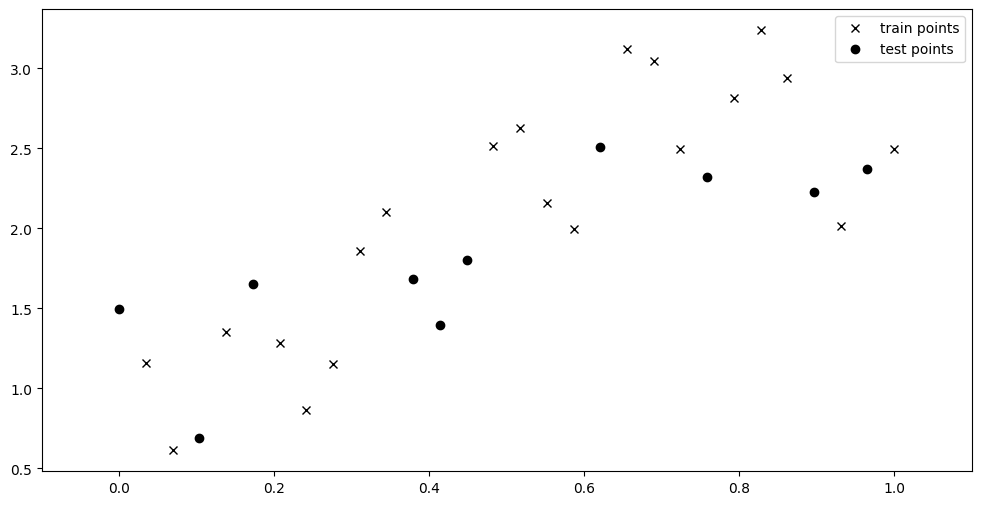

In [110]:
# generate data and plot it
N = 30
X = []
for i in range(1, 31):
    xi = (i - 1)/(30 - 1)
    X.append(xi)

X = torch.tensor(X)
noise = dist.Normal(0.0, 0.01).sample(sample_shape=(N,))
y = -(torch.sin(6 * torch.pi * X))**2 + 6 * X**2 - 5 * X**4 + 3/2 + noise

# split into train and test
indices = torch.randperm(len(X))[:20]
first = torch.arange(0, 30, 1)
diff=first[(first.view(1, -1) != indices.view(-1, 1)).all(dim=0)]

X_train = X[indices]
y_train = y[indices]

X_test = X[diff]
y_test = y[diff]



plot(X_train, y_train, X_test, y_test)  # let's plot the observed data
_ = plt.xlim((-0.1, 1.1))

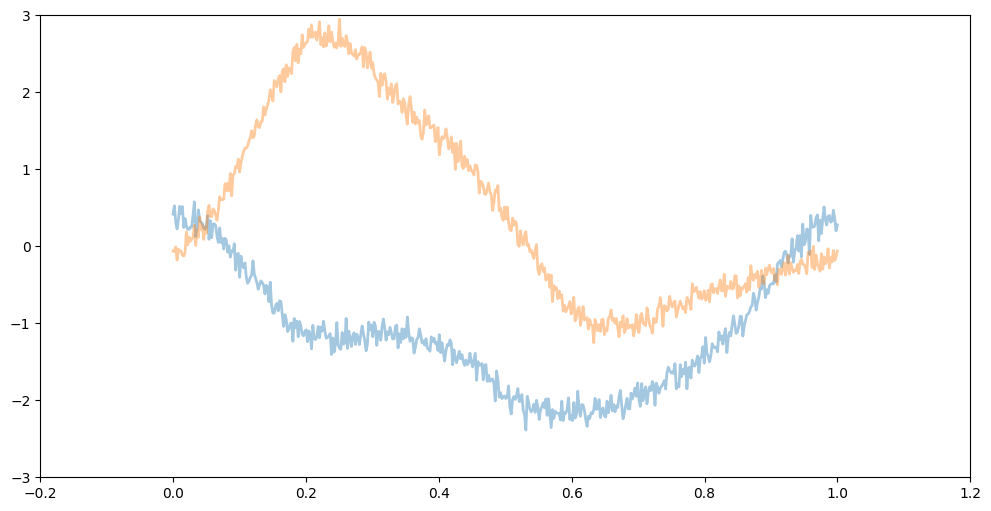

In [60]:
# define kernel with some values and visualize it
pyro.clear_param_store()
kernel = gp.kernels.Periodic(
    input_dim=1, variance=torch.tensor(1.0),
    lengthscale=torch.tensor(1.0),
    period=torch.tensor(1.0) 
)
gpr = gp.models.GPRegression(X_train, y_train, kernel, noise=torch.tensor(0.01))

# plot to see
plot(model=gpr, kernel=kernel, n_prior_samples=2)
_ = plt.ylim((-3, 3))

In [61]:
# fig, ax = plt.subplots(figsize=(12, 6))

# def update(iteration):
#     pyro.clear_param_store()
#     ax.cla()
#     kernel_iter = gp.kernels.RBF(
#         input_dim=1,
#         variance=torch.tensor(variances[iteration]),
#         lengthscale=torch.tensor(lengthscales[iteration]),
#     )
#     gpr_iter = gp.models.GPRegression(
#         X, y, kernel_iter, noise=torch.tensor(noises[iteration])
#     )
#     plot(model=gpr_iter, plot_observed_data=True, plot_predictions=True, ax=ax)
#     ax.set_title(f"Iteration: {iteration}, Loss: {losses[iteration]:0.2f}")


# anim = FuncAnimation(fig, update, frames=np.arange(0, num_steps, 30), interval=100)
# plt.close()
# anim.save("./source/gpr-fit.gif", fps=60)

model


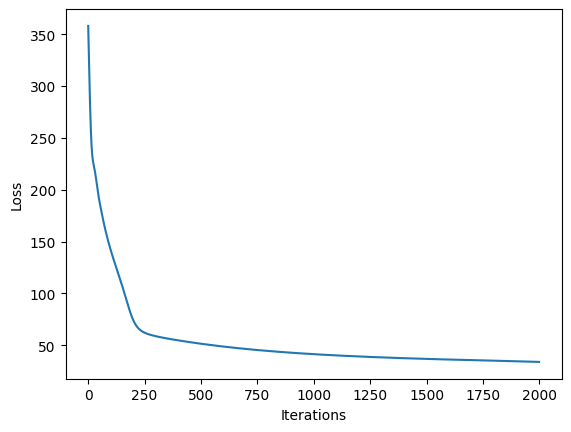

In [103]:
# now lets set some priors
pyro.clear_param_store()

# define model
kernel = gp.kernels.Periodic(
    input_dim=1
)
gpr = gp.models.GPRegression(X_train, y_train, kernel, noise=torch.tensor(0.01))

# set prior mean and variance for each param
mu = 0.
var = 0.5

# set priors on the kernel
gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(mu, var))
gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(mu, var))
gpr.kernel.period = pyro.nn.PyroSample(dist.LogNormal(mu, var))

# create joint prior distribution
mean = torch.tensor([mu, mu, mu])
covar = torch.diag(torch.tensor([var, var, var]))

prior = dist.MultivariateNormal(loc=mean, covariance_matrix=covar)

# LogNormal - obtained by transforming the multivariate normal Y ~ exp(X)
prior = dist.TransformedDistribution(
    dist.MultivariateNormal(loc=mean, covariance_matrix=covar),
    dist.transforms.ExpTransform()
)

# perform gradient descent to optimize parameters
optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 2000
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plot_loss(losses)

In [114]:
plot(model=gpr, plot_observed_data=True, plot_predictions=True, plot_test_points=True)
_ = plt.xlim(0, 1)

TypeError: plot() got an unexpected keyword argument 'plot_observed_data'

In [105]:
gpr.set_mode("guide")
print("variance = {}".format(gpr.kernel.variance))
print("lengthscale = {}".format(gpr.kernel.lengthscale))
print("period = {}".format(gpr.kernel.period))
print("noise = {}".format(gpr.noise))

variance = 1.7229058742523193
lengthscale = 0.4936797618865967
period = 0.7307054996490479
noise = 0.13900598883628845


In [365]:
def logLikelihood(params, gpr, X, y, prior):
    l = y.shape[0]
    noise_y = gpr.noise
    K = gpr.kernel(X, X)
    sigma_y_I = noise_y * torch.eye(l)
    inverse = torch.linalg.inv((sigma_y_I + K))
    det = torch.linalg.det((sigma_y_I + K))
    sqrt = torch.sqrt(2 * torch.pi)

    evidence_ll = -0.5 * (y.T @ inverse @ y + torch.log(det) + l * torch.log(sqrt))
    prior_prob = prior.log_prob(params)

    return evidence_ll + prior_prob

In [28]:
# sample using NUTS
n_samples = 500
n_chains = 2
n_warmup = 100

pyro.clear_param_store()
# compute second moment quantity
nuts_kernel = pyro.infer.NUTS(gpr.model, jit_compile=True)
mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=n_samples,
                       num_chains=n_chains)
mcmc.run()

Warmup [1]:   0%|          | 0/1000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/1000 [00:00, ?it/s]

/Users/madsfrandsen/Documents/MLA/venv/lib/python3.9/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(



                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      1.63      0.53      1.56      0.72      2.38    215.30      1.01
       kernel.period      1.60      0.50      1.45      1.01      2.22    211.50      1.02
     kernel.variance      1.56      0.61      1.44      0.70      2.52    553.74      1.00

Number of divergences: 0
None


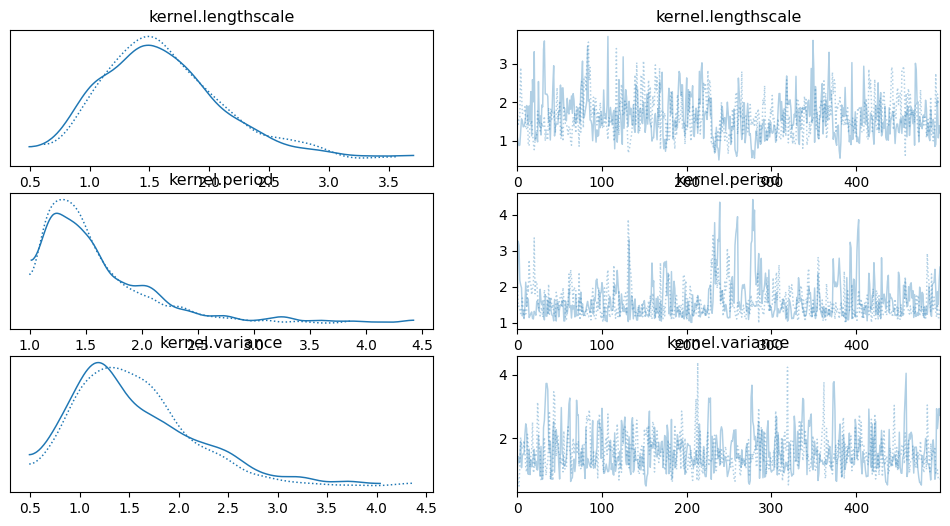

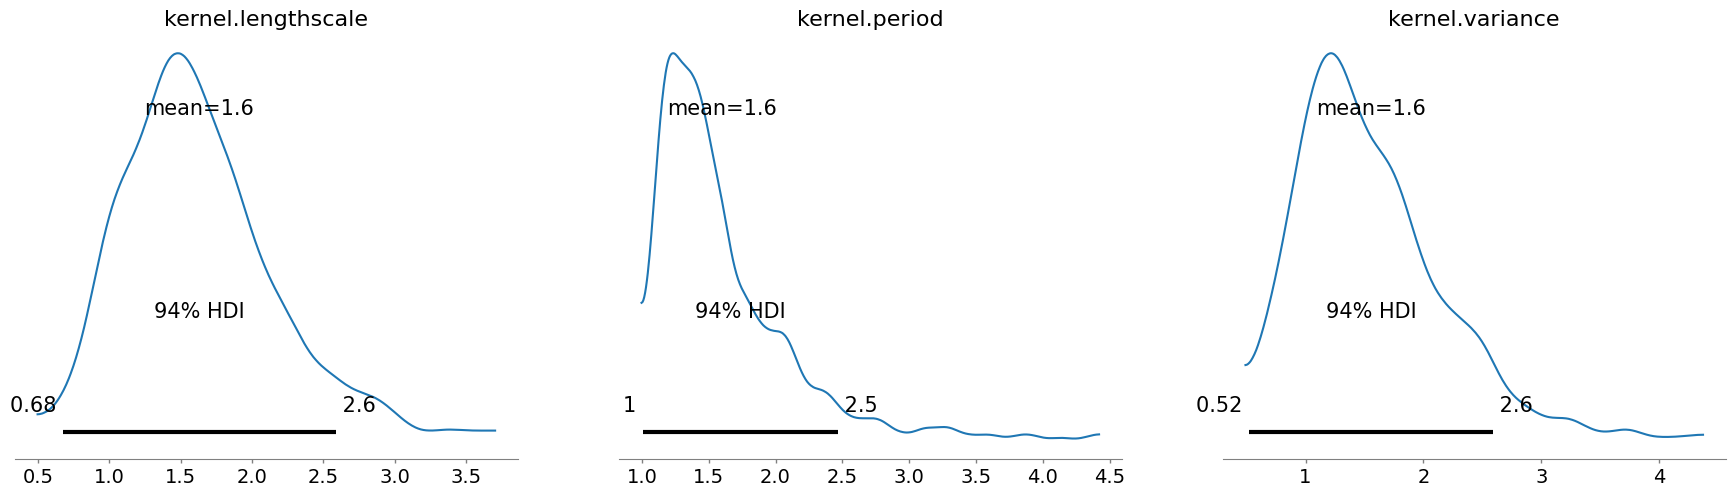

In [373]:
# inspect posterior
samples = mcmc.get_samples()
sample_data = az.from_pyro(mcmc)
sample_summary = az.summary(sample_data)


print(mcmc.summary())
az.plot_trace(sample_data)
plt.show()
az.plot_posterior(sample_data)
plt.show()

In [112]:
# lets generate 20 datasets
xtrains = []
xtests = []
ytrains = []
ytests = []
indix = []

l = 30
X = []
for i in range(1, 31):
    xi = (i - 1)/(l - 1)
    X.append(xi)
X = torch.tensor(X)

for k in range(20):
    # set seeds
    torch.manual_seed(k)
    pyro.set_rng_seed(k)
    
    # generate points
    noise = dist.Normal(0.0, 0.01).sample(sample_shape=(N,))
    y = -(torch.sin(6 * torch.pi * X))**2 + 6 * X**2 - 5 * X**4 + 1.5 + noise
    
    # split into train and test
    indices = torch.randperm(len(X))[:20]
    first = torch.arange(0, 30, 1)
    diff=first[(first.view(1, -1) != indices.view(-1, 1)).all(dim=0)]
    
    X_train = X[indices]
    y_train = y[indices]
    
    X_test = X[diff]
    y_test = y[diff]
    
    xtrains.append(X_train)
    ytrains.append(y_train)
    xtests.append(X_test)
    ytests.append(y_test)

variance = 1.9788596630096436
lengthscale = 0.4412694275379181
period = 1.0539443492889404
noise = 0.0041390699334442616


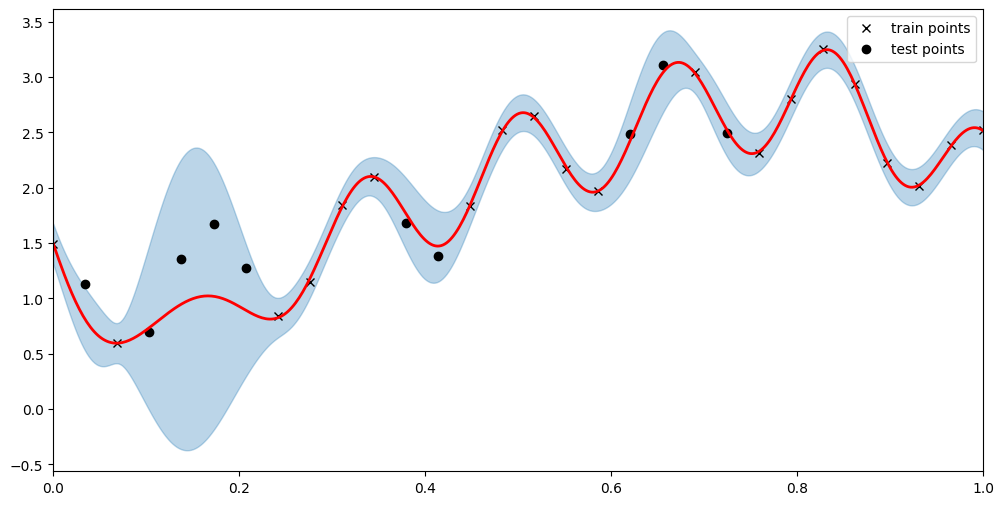

variance = 1.1470094919204712
lengthscale = 1.6772574186325073
period = 1.2456613779067993
noise = 0.10054485499858856


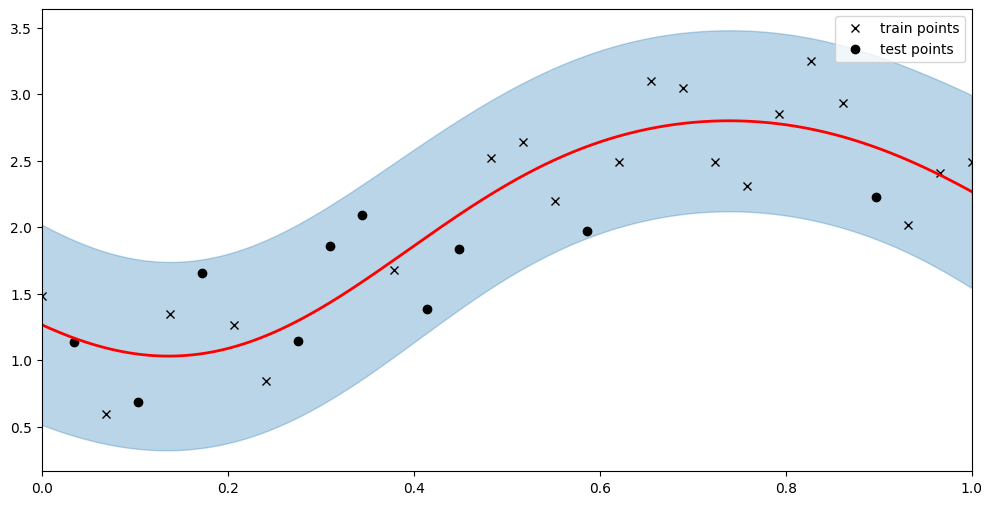

variance = 2.9440786838531494
lengthscale = 0.15549470484256744
period = 0.7385808229446411
noise = 0.025718243792653084


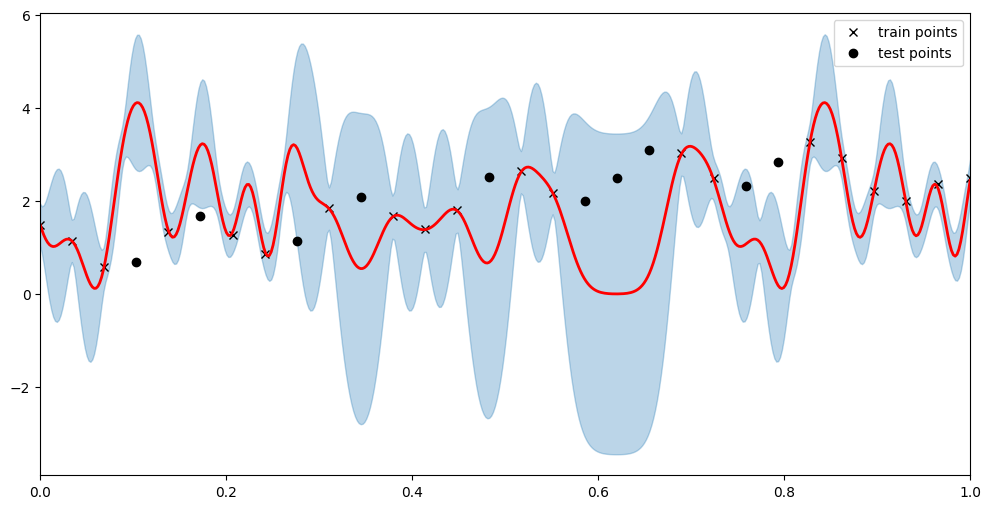

variance = 1.8773548603057861
lengthscale = 0.4289194643497467
period = 1.070299506187439
noise = 0.012870210222899914


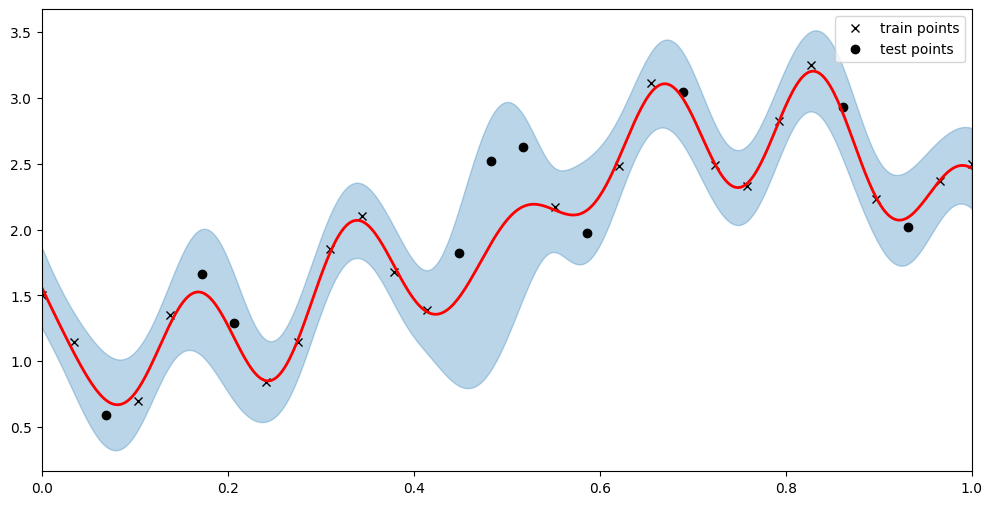

variance = 1.9578089714050293
lengthscale = 0.41756075620651245
period = 1.0869481563568115
noise = 0.0072448840364813805


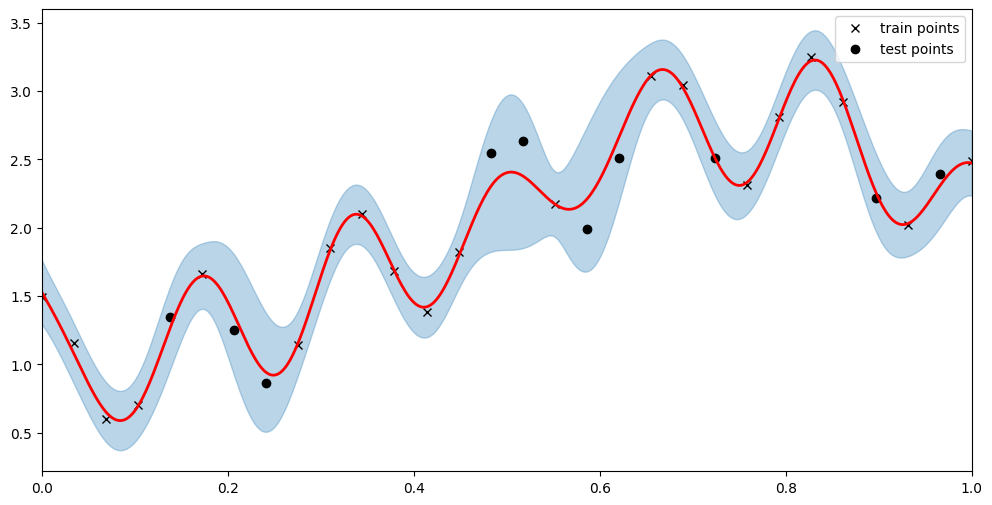

variance = 1.9571267366409302
lengthscale = 0.43210911750793457
period = 1.0702505111694336
noise = 0.013638735748827457


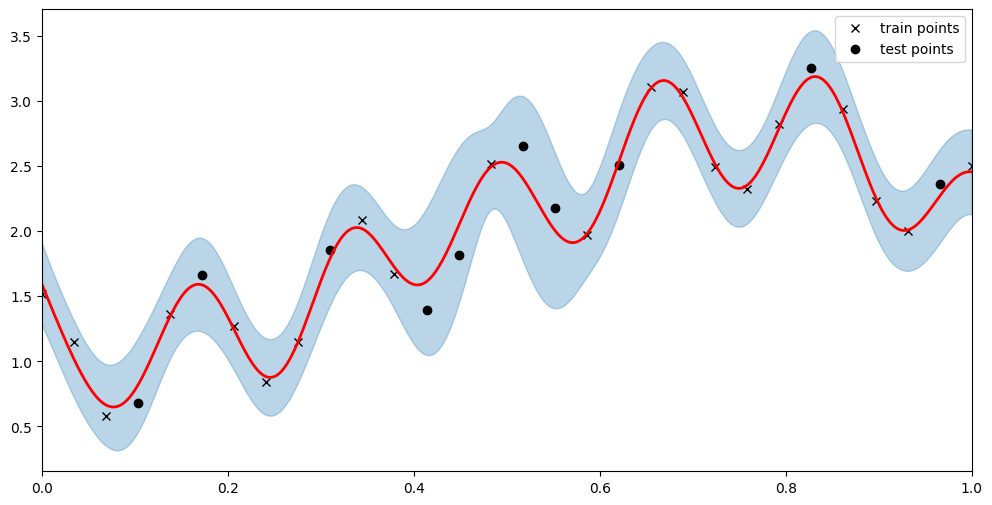

variance = 2.71085786819458
lengthscale = 0.1933266818523407
period = 0.671006441116333
noise = 0.022966677322983742


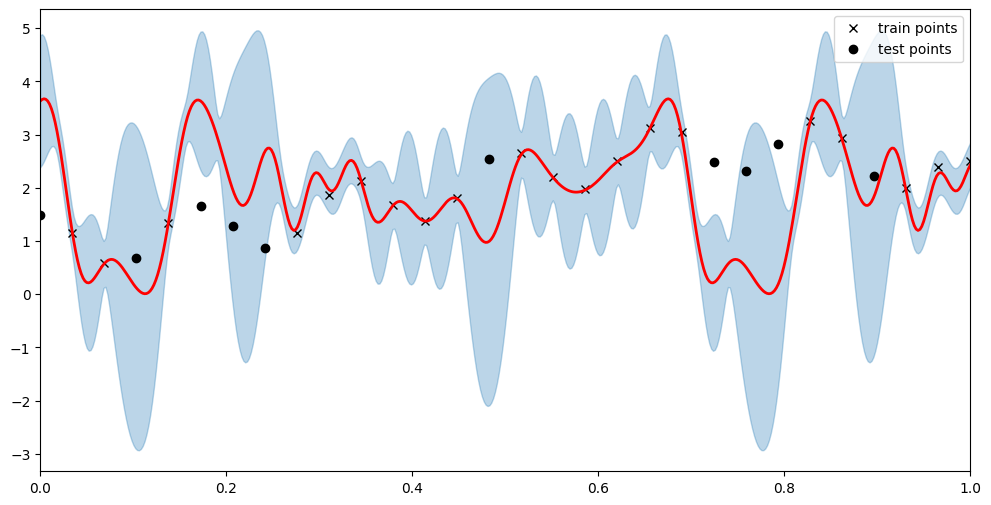

variance = 1.119661808013916
lengthscale = 1.6512155532836914
period = 1.309497594833374
noise = 0.14405255019664764


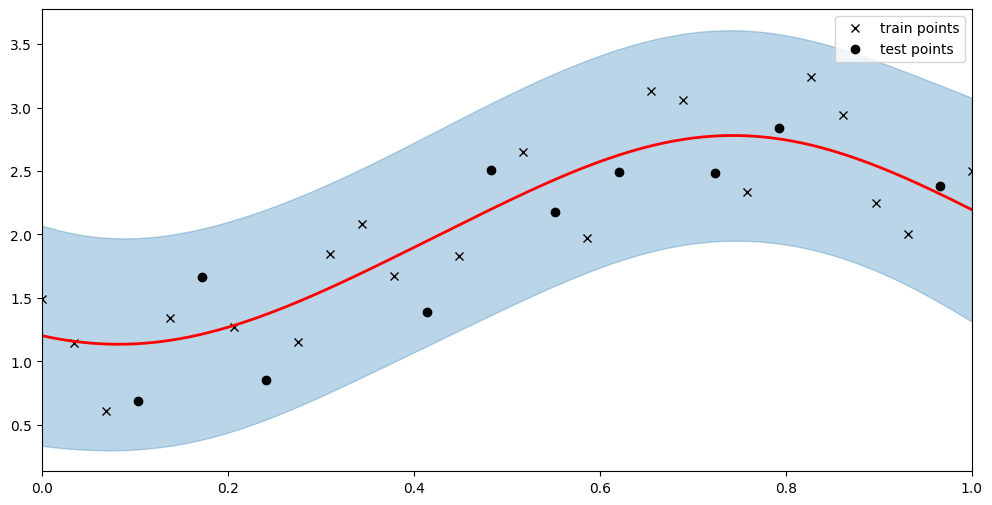

variance = 1.8099044561386108
lengthscale = 0.44395363330841064
period = 1.0679271221160889
noise = 0.019097646698355675


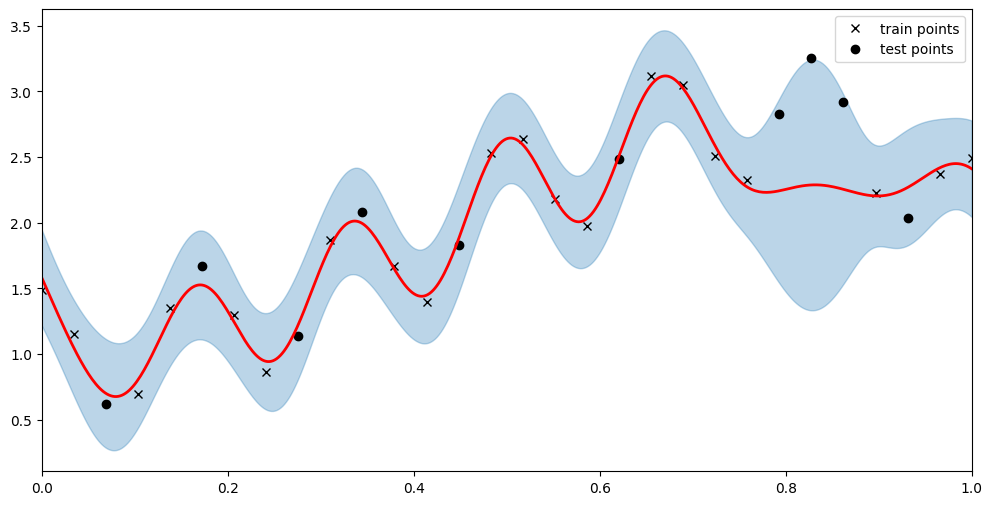

variance = 2.0295238494873047
lengthscale = 0.43916183710098267
period = 1.0360857248306274
noise = 0.005815276876091957


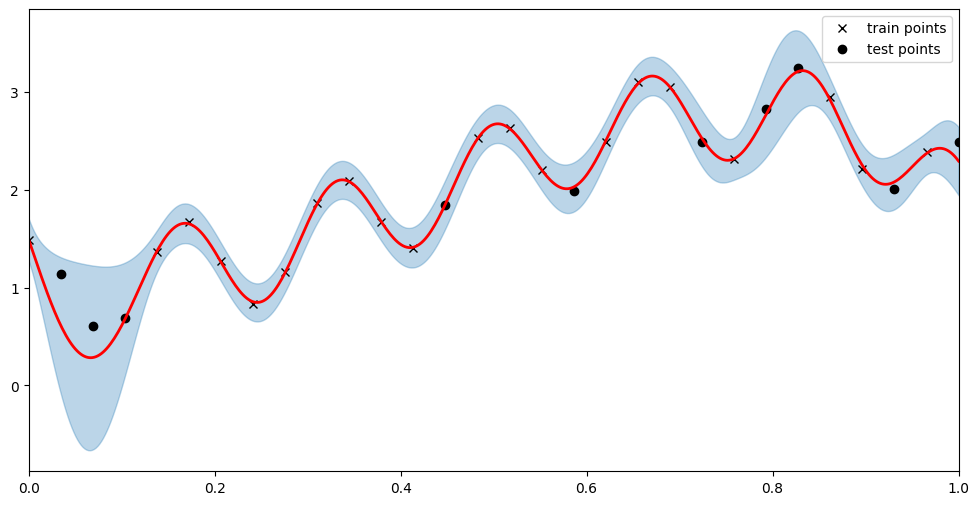

variance = 1.1355608701705933
lengthscale = 1.658129096031189
period = 1.2209547758102417
noise = 0.11260785162448883


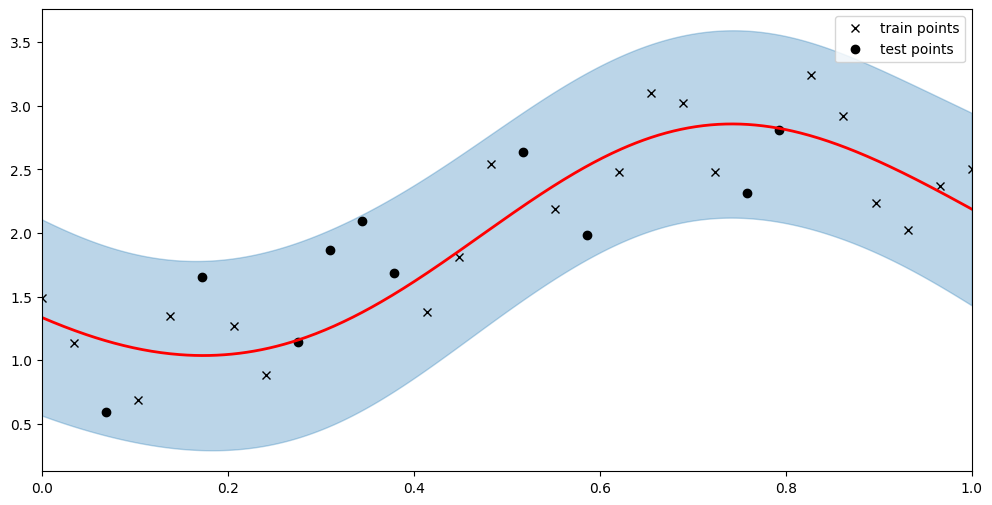

variance = 2.0581936836242676
lengthscale = 0.45530396699905396
period = 1.0299336910247803
noise = 0.005060337483882904


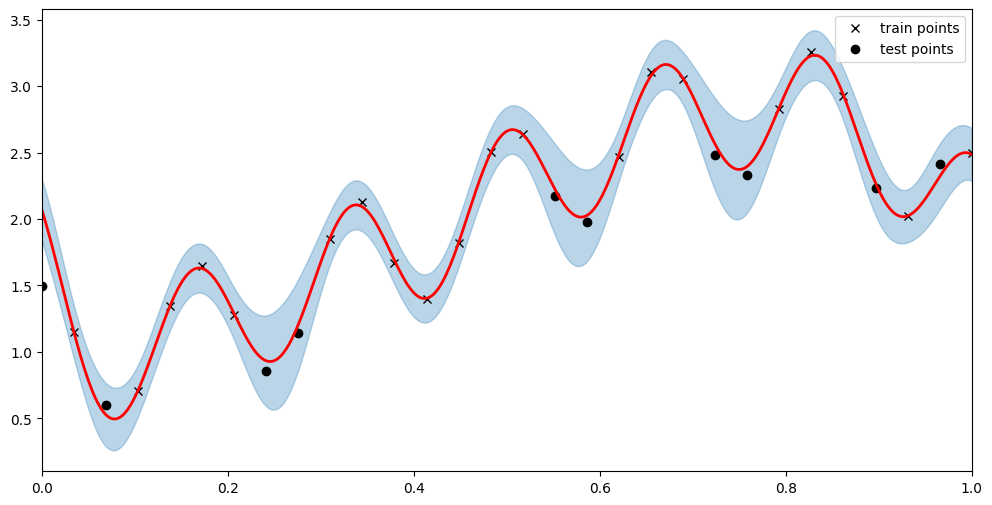

variance = 1.078832745552063
lengthscale = 1.504894733428955
period = 1.7689204216003418
noise = 0.11451615393161774


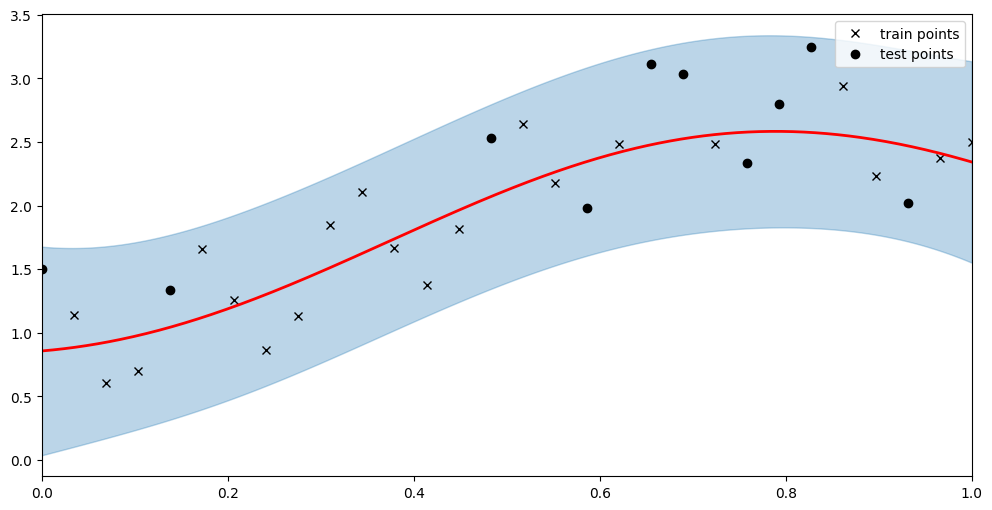

variance = 2.040654420852661
lengthscale = 0.4159313440322876
period = 1.0957508087158203
noise = 0.0028183921240270138


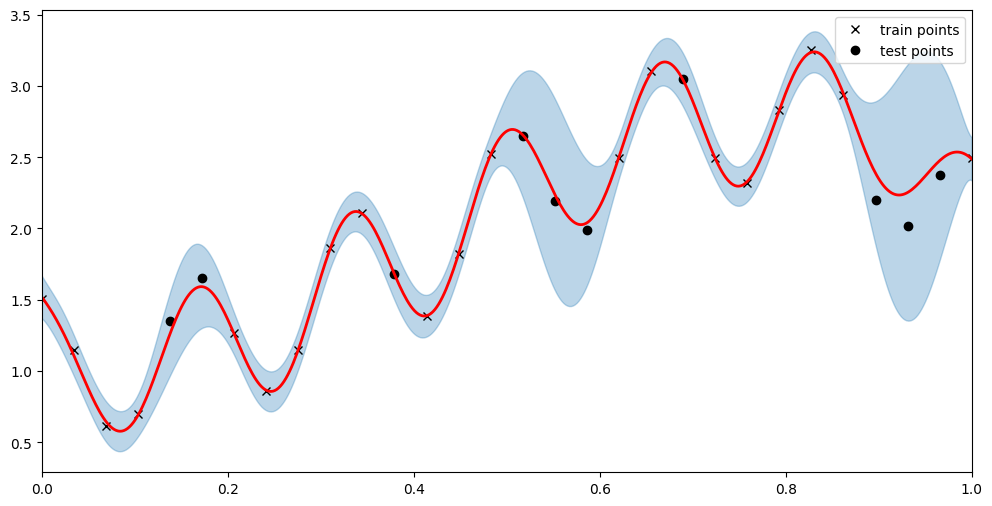

variance = 1.7024962902069092
lengthscale = 0.6693805456161499
period = 0.6760442852973938
noise = 0.264721542596817


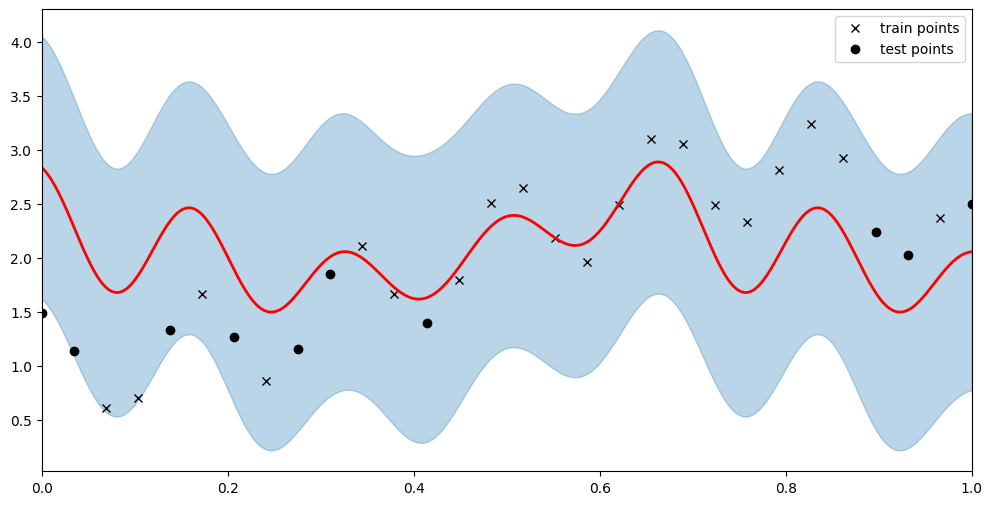

variance = 1.0609532594680786
lengthscale = 1.7242159843444824
period = 1.3853431940078735
noise = 0.1270206868648529


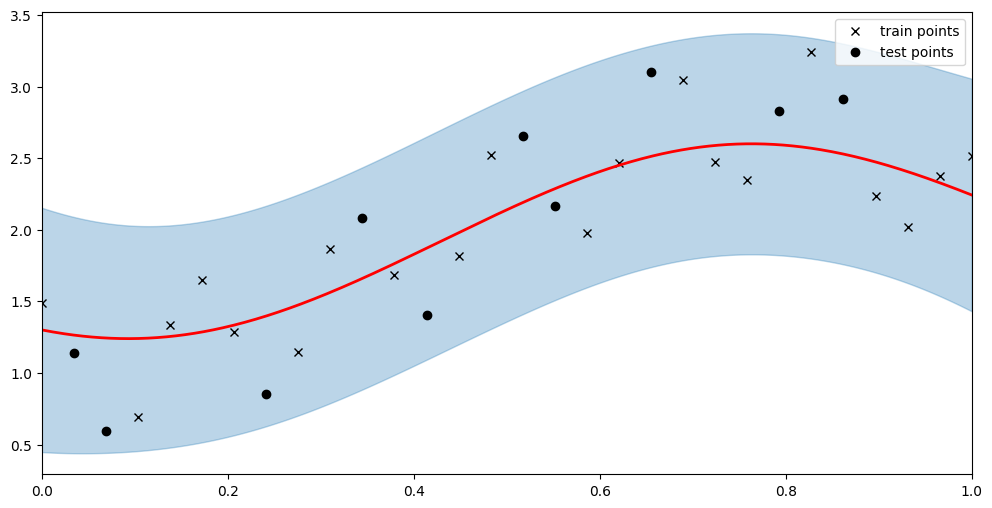

variance = 1.127902865409851
lengthscale = 1.5955547094345093
period = 1.2334896326065063
noise = 0.11807128041982651


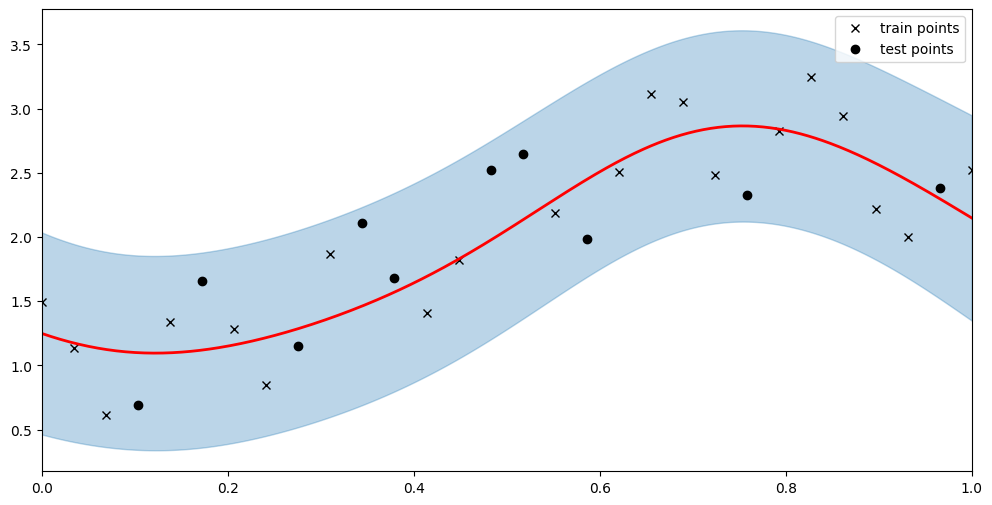

variance = 2.625805377960205
lengthscale = 0.19212277233600616
period = 0.5361394882202148
noise = 0.028645779937505722


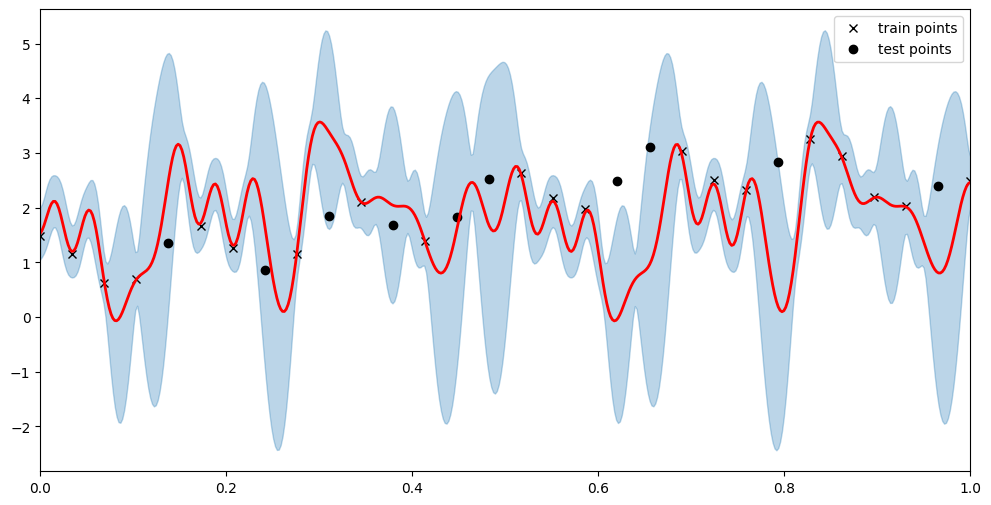

variance = 2.009634256362915
lengthscale = 0.41891178488731384
period = 1.0840615034103394
noise = 0.003797269659116864


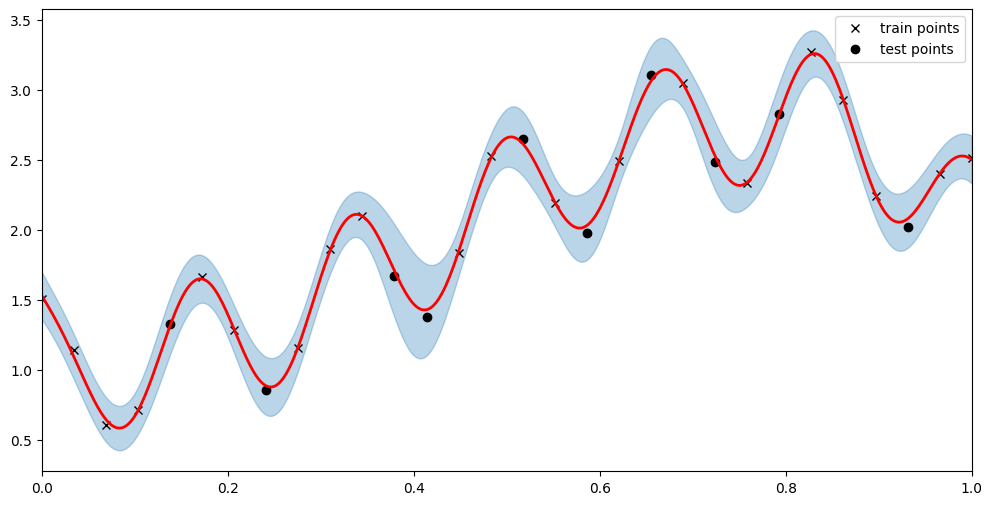

variance = 2.4478111267089844
lengthscale = 0.20937451720237732
period = 0.5338231921195984
noise = 0.01924324221909046


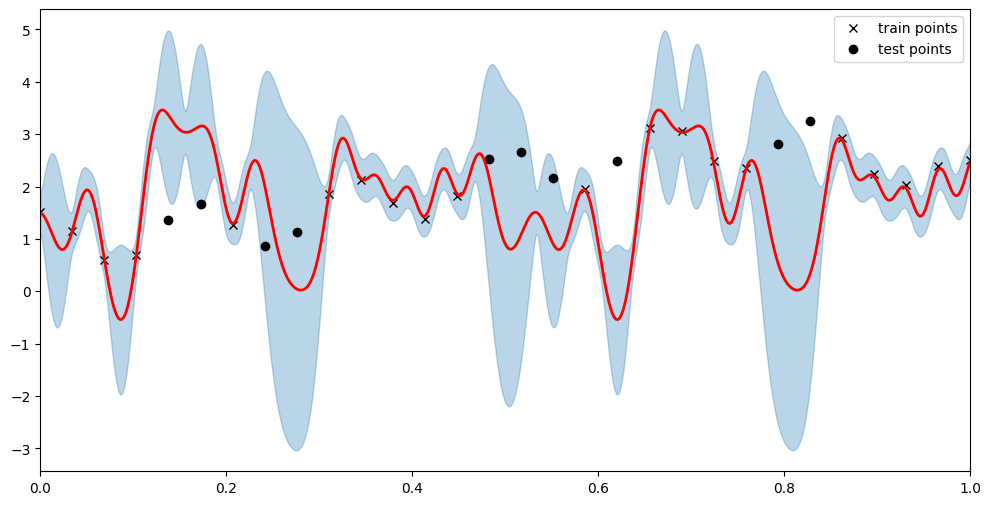

In [115]:
ypreds = []
testlikelihoods = []

# prior mean and var
mu = 0.
var = 0.5

# create joint prior distribution
mean = torch.tensor([mu, mu, mu])
covar = torch.diag(torch.tensor([var, var, var]))

prior = dist.MultivariateNormal(loc=mean, covariance_matrix=covar)

# LogNormal - obtained by transforming the multivariate normal Y ~ exp(X)
prior = dist.TransformedDistribution(
    dist.MultivariateNormal(loc=mean, covariance_matrix=covar),
    dist.transforms.ExpTransform()
)


for k in range(20):
    pyro.clear_param_store()

    # define model
    kernel = gp.kernels.Periodic(
        input_dim=1
    )
    gpr = gp.models.GPRegression(xtrains[k], ytrains[k], kernel, noise=torch.tensor(0.01))

    # set priors on the kernel
    gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(mu, var))
    gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(mu, var))
    gpr.kernel.period = pyro.nn.PyroSample(dist.LogNormal(mu, var))
    gpr.set_mode("model")

    # perform gradient descent to optimize parameters
    optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
    loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
    losses = []
    num_steps = 2000
    for i in range(num_steps):
        optimizer.zero_grad()
        loss = loss_fn(gpr.model, gpr.guide)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    
    # print params after training
    gpr.set_mode("guide")
    print("variance = {}".format(gpr.kernel.variance))
    print("lengthscale = {}".format(gpr.kernel.lengthscale))
    print("period = {}".format(gpr.kernel.period))
    print("noise = {}".format(gpr.noise))
    
    # generate plot
    plot(model=gpr, X_train=xtrains[k], y_train=ytrains[k], X_test=xtests[k], y_test=ytests[k], plot_predictions=True)
    _ = plt.xlim(0, 1)
    plt.show()
    
    
    

    # plot_loss(losses)